In [18]:
%matplotlib inline
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import seaborn as sns

We set parameter values

In [3]:
l_vec = np.array([0.1, 1, 1.25])
Z = 0.1
alpha = 0.3
B = 0.1
b_max = 2;
beta = 0.95;
N_b = 501;
T = 20000;
psi = 0.0001
K_0 = 0.398

nlsize = 3;
P = np.array([[.4,.5,.1],[.2, .7, .1],[.2, .1, .7]])
epsilon = 0.25
mu = 0.03

tol_inner = 1e-6
tol_outer = 1e-6
tol = 1e-6

Ergodic density of individuals over productivity states

In [4]:
def calc_ergodic_density():
    H = P
    for i in range(1000):
        H_new = H.dot(P)
        error = np.max(H - H_new)
        if error < tol:
            return H_new    
        H = H_new;
    return None

f = calc_ergodic_density()[0,:]

Aggregate labor

In [5]:
L = f.dot(l_vec)

Asset grid

In [6]:
agrid = np.linspace(-B, b_max, N_b); 
apgrid = np.linspace(-B, b_max, N_b);

In [7]:
def calc_prices(K):
    r = Z * alpha * (K**(alpha-1)) * (L**(1-alpha))
    w = Z * (1-alpha) * (K**alpha) * (L**(-alpha))
    utilgrid = np.zeros((N_b, N_b, nlsize))
    for a in range(N_b):
        for ap in range(N_b):
            for l in range(nlsize):
                consumption = (1+r) * agrid[a] + w * l_vec[l] - apgrid[ap]
                if consumption <= 0:
                    utilgrid[a,ap,l] = -1000
                else:
                    utilgrid[a,ap,l] = np.log(consumption)
    return utilgrid, r, w

In [8]:
opt_calc_prices = jit(calc_prices)

In [9]:
def vfi_func(utilgrid, initial_V):
    V = initial_V.copy()
    V_new = V.copy()
    index = np.zeros((N_b, nlsize))
    for i in range(1000):
        for a in range(N_b):
            for z in range(nlsize):
                index[a,z] = np.argmax(utilgrid[a,:,z] + beta * np.dot(P[z,:], V.T))
                V_new[a,z] = np.max(utilgrid[a,:,z] + beta * np.dot(P[z,:], V.T))
        error_inner = np.max(np.abs(V - V_new).flatten()) 
        if error_inner < tol_inner:
            return V_new, index.astype(int)
        V = V_new.copy()
    return None

In [10]:
def calc_policy(index, r, w):
    a_policy = agrid[index]
    c_policy = (1+r) * np.tile(agrid.T,(1,3)).reshape(501, 3) + w * np.tile(l_vec, (N_b, 1)) - a_policy
    return a_policy, c_policy

In [21]:
def calc_simulation(a_policy):
    l_sim = np.zeros((T, 1))
    l_sim[0] = l_vec[1]
    l_sim_index = np.zeros((T, 1), dtype = int)
    l_sim_index[0] = 1
    rand_nums = np.random.rand(T)
    for i in range(1, T):
        dist = P[l_sim_index[i-1], :]
        cum_dist = np.cumsum(dist)
        r = rand_nums[i]
        l_sim_index[i] = np.argwhere(cum_dist > r)[0]
        l_sim[i] = l_vec[l_sim_index[i]]
    asim = np.zeros((T, 1))
    asim[0] = agrid[250]
    asim_index = np.zeros((T, 1), dtype = int)
    asim_index[0] = 250
    for t in range(1, T):
        asim[t] = a_policy[asim_index[t-1], l_sim_index[t]]
        asim_index[t] = np.argwhere(agrid == asim[t])
    K_new = np.mean(asim[(T//5):])
    #K_d = ((r / (Z * alpha)) ** (1/(alpha - 1)))*L
    return asim_index, l_sim_index, K_new

In [22]:
opt_calc_simulation = jit(calc_simulation)

In [23]:
def full_loop(n_iter=1000, initial_k = K_0):
    K = initial_k
    for t_outer in range(n_iter):
        value_func = np.zeros((N_b, nlsize))
        utilgrid, r, w = opt_calc_prices(K)
        value_func, p_index = vfi_func(utilgrid, value_func)
        a_policy, c_policy = calc_policy(p_index, r, w)
        asim_index, l_sim_index, K_new = calc_simulation(a_policy)
        K_update = psi*K_new + (1-psi)*K
        if np.max(np.abs(K_update - K)) < tol_outer:
            r = Z * alpha * (K**(alpha-1)) * (L**(1-alpha))
            w = Z * (1-alpha) * (K**alpha) * (L**(-alpha))
            return K, w, r, c_policy, asim_index, l_sim_index, value_func
        print(K)
        K = K_update
    return None

In [29]:
some_results = full_loop(initial_k=0.398)

0.398
0.397991305006
0.397984819006
0.39797510577
0.397965491497
0.397957342752
0.397953474516
0.397949145455
0.397943848727
0.397935171554
0.397930644272
0.397924645579
0.397917765039
0.397914334123
0.397902626531
0.397896564516
0.397894945
0.397889462986
0.397880768808
0.397874471889
0.397867829335
0.397864485234
0.397858733501
0.397849917762
0.397844125591
0.397840402133
0.397829629609
0.397823660757
0.397815419935
0.397807118538
0.397797410262
0.397789998782
0.397785460135
0.397779012726
0.397772165886
0.397763500317
0.397759776888
0.397752980771
0.39774533079
0.397736316968
0.397727258032
0.397721209248
0.397715776947
0.397704264246
0.3976963926
0.397693143341
0.397687617982
0.397677587389
0.39767218024
0.397664598479
0.397656268668
0.397648670437
0.397638560316
0.397635454654
0.397629552128
0.397620377711
0.397619189119
0.39760749789
0.397599978903
0.397596452978
0.397587824982
0.397581544783
0.397572070351
0.397561087256
0.397550649289
0.397543516953
0.397537895703
0.39753207913

In [30]:
some_results[0]

0.39690990691136996

In [31]:
some_results[1]

0.055951301548212436

In [32]:
some_results[2]

0.050597170360508821

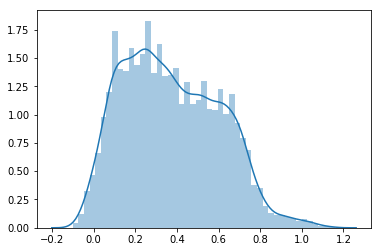

In [33]:
sns.distplot(agrid[some_results[4]])